In [1]:
import os
os.environ["CUDA_TF32_OVERRIDE"] = "0"

In [2]:
import yaml
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import torch

from pdearena.models.pderefiner import PDERefiner
from pdearena.data.utils import PDEDataConfig
from pdearena.data.datamodule import PDEDataModule
from pytorch_lightning import seed_everything
seed_everything(42)

/home/davidwagner/miniforge3/envs/pdearena/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 42


42

In [3]:
config = yaml.safe_load(Path("/home/davidwagner/git/pdearena/configs/kuramotosivashinsky1d.yaml").read_bytes())
config["data"]["num_workers"] = 0
config["data"]["batch_size"] = 1
config["data"]["data_dir"] = "/home/davidwagner/data/"
config["data"]["pde"] = PDEDataConfig(**config["data"]["pde"])

In [4]:
config["data"]["pde"]

PDEDataConfig(n_scalar_components=1, n_vector_components=0, trajlen=640, n_spatial_dim=1)

In [5]:
# usegrid can output sptail grid, np.linspace
dm = PDEDataModule(
    **config["data"]
)

In [6]:
dm.setup()

Loading train data from 1 files.
Loading valid data from 0 files.
Loading valid data from 0 files.
Loading test data from 1 files.
Loading test data from 1 files.


In [7]:
model = PDERefiner.load_from_checkpoint("/home/davidwagner/git/pdearena/outputs/ckpts/epoch_049.ckpt", pdeconfig=config["data"]["pde"])

In [8]:
model.eval();

In [9]:
device = torch.device("cuda:0")
model.to(device);

In [10]:
import h5py

In [11]:
f = h5py.File("/home/davidwagner/data/KS_test_2048.h5")

In [12]:
data = f["train"]

In [13]:
u = data["pde_640-256"]

# DataLoader Short

In [34]:
%%time
ts_dl, test_dl = dm.test_dataloader()
for sample_idx, data in enumerate(test_dl):
    # torch.save(data, f"/home/davidwagner/data/test/{sample_idx}.pth")
    u, v, cond, grid = data
    print(u.shape)
    collect = [u[:, :1, :, :].to(device)]
    for seq_idx in range(159):
        x = model(collect[-1], cond[:1].to(device))
        collect.append(x)
    predict = torch.concat(collect)
    predict = predict[:, 0, 0, :].detach().cpu().numpy()
    break
    # torch.save(predict, f"/home/davidwagner/data/test/{sample_idx}_predict.pth")

torch.Size([1, 160, 1, 256])
CPU times: user 51.9 s, sys: 1.75 s, total: 53.7 s
Wall time: 10.1 s


# Long

In [19]:
data["dt"][1]

0.20276801878351616

In [14]:
%%time
for sample_idx in range(2048):
    u = torch.tensor(data["pde_640-256"][sample_idx][:].astype(np.float32))
    cond = torch.tensor([data["dt"][sample_idx], data["dx"][sample_idx]])[None]
    torch.save([u, cond], f"/home/davidwagner/data/test_long_notf32/{sample_idx}.pth")
    collect = [u[0][None, None, None, :].to(device)]
    for seq_idx in range(639):
        x = model(collect[-1], cond[:1].to(device))
        collect.append(x)
    predict = torch.concat(collect)
    predict = predict[:, 0, 0, :].detach().cpu().numpy()
    torch.save(predict, f"/home/davidwagner/data/test_long_notf32/{sample_idx}_predict.pth")

KeyboardInterrupt: 

In [41]:
u.shape

torch.Size([1, 160, 1, 256])

In [33]:
u.sh

torch.Size([640, 256])

In [18]:
u.shape

(2048, 640, 256)

In [21]:
truth = u[0, :, :]

In [12]:
truth = u[0, :, 0, :].numpy()

In [22]:
truth.shape

(640, 256)

In [23]:
predict.shape

(160, 256)

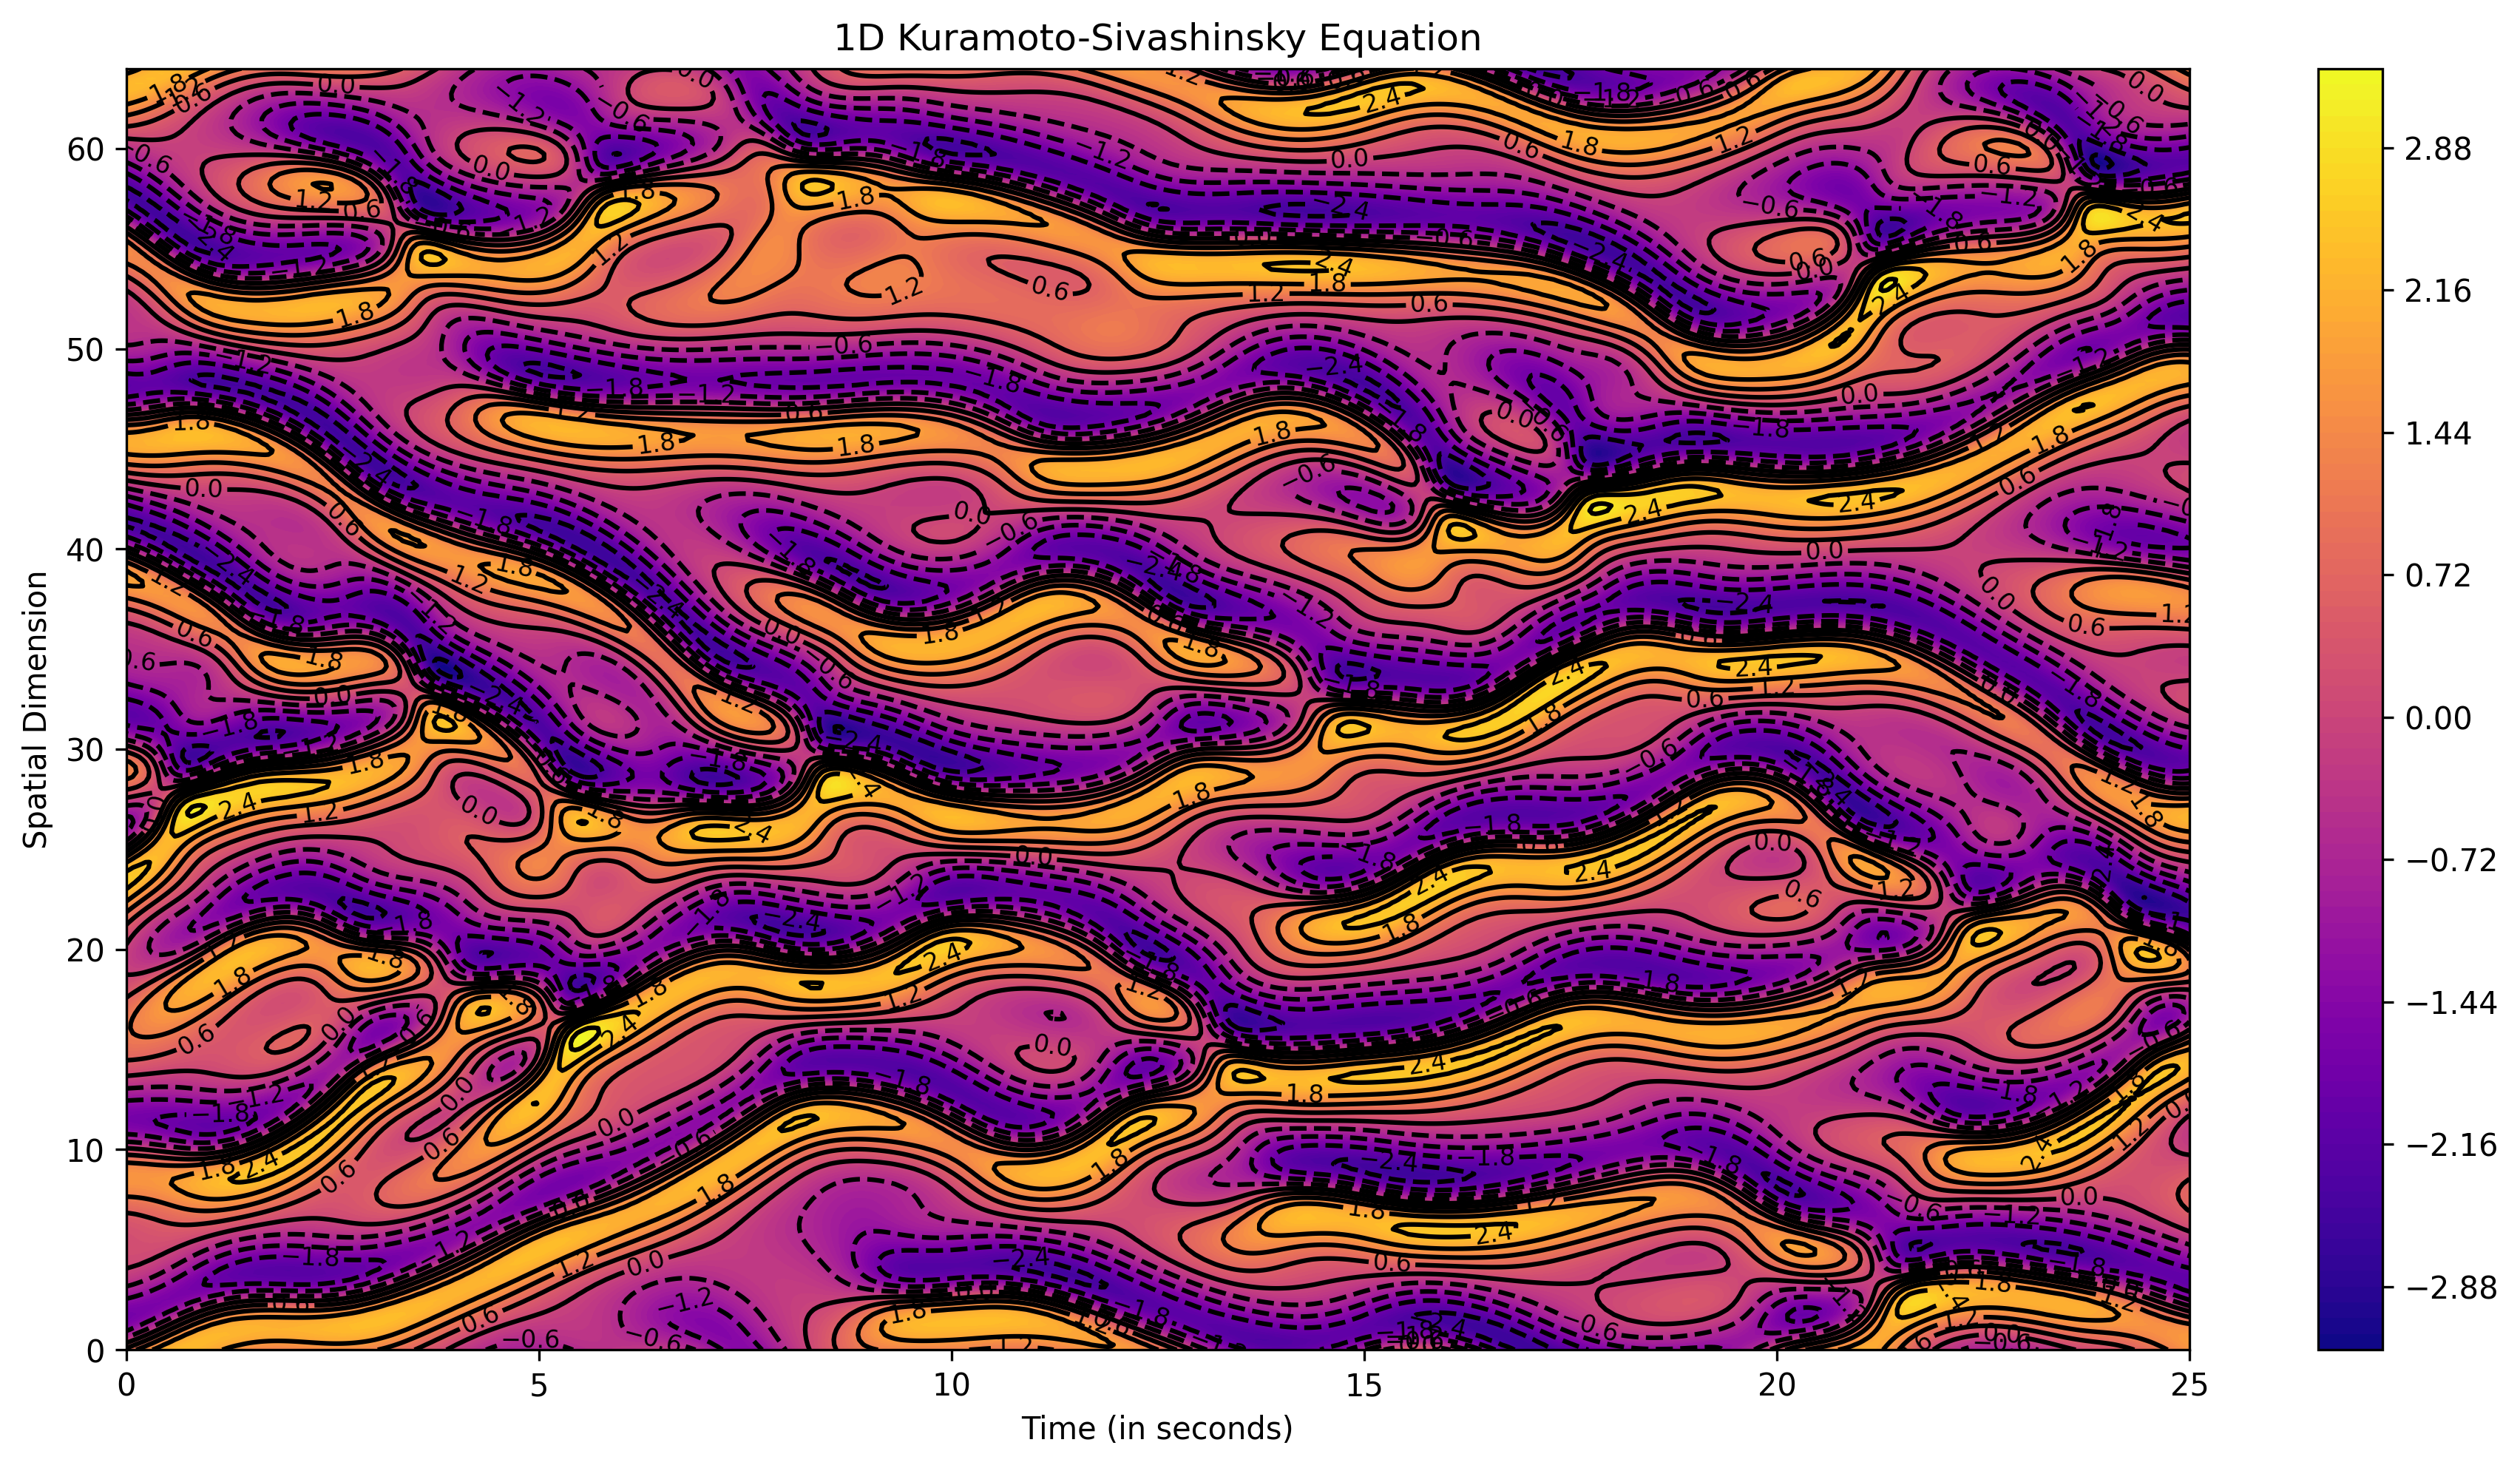

In [24]:
num_time_steps = truth.shape[0]
num_spatial_points = truth.shape[1]
t_start = 0
t_end = int(128 * 0.2)
x_start = 0
x_end = 64
t_eval = np.linspace(t_start, t_end, num_time_steps)
x = np.linspace(x_start, x_end, num_spatial_points)
T, X = np.meshgrid(t_eval, x)
plt.figure(figsize=(15, 7.5), dpi=300)
contourf = plt.contourf(T, X, truth.T, 100, cmap='plasma')
plt.colorbar(contourf)
contours = plt.contour(T, X, truth.T, 10, colors='black')
plt.clabel(contours, inline=True, fontsize=8)
plt.title('1D Kuramoto-Sivashinsky Equation')
plt.xlabel('Time (in seconds)')
plt.ylabel('Spatial Dimension')
plt.show()

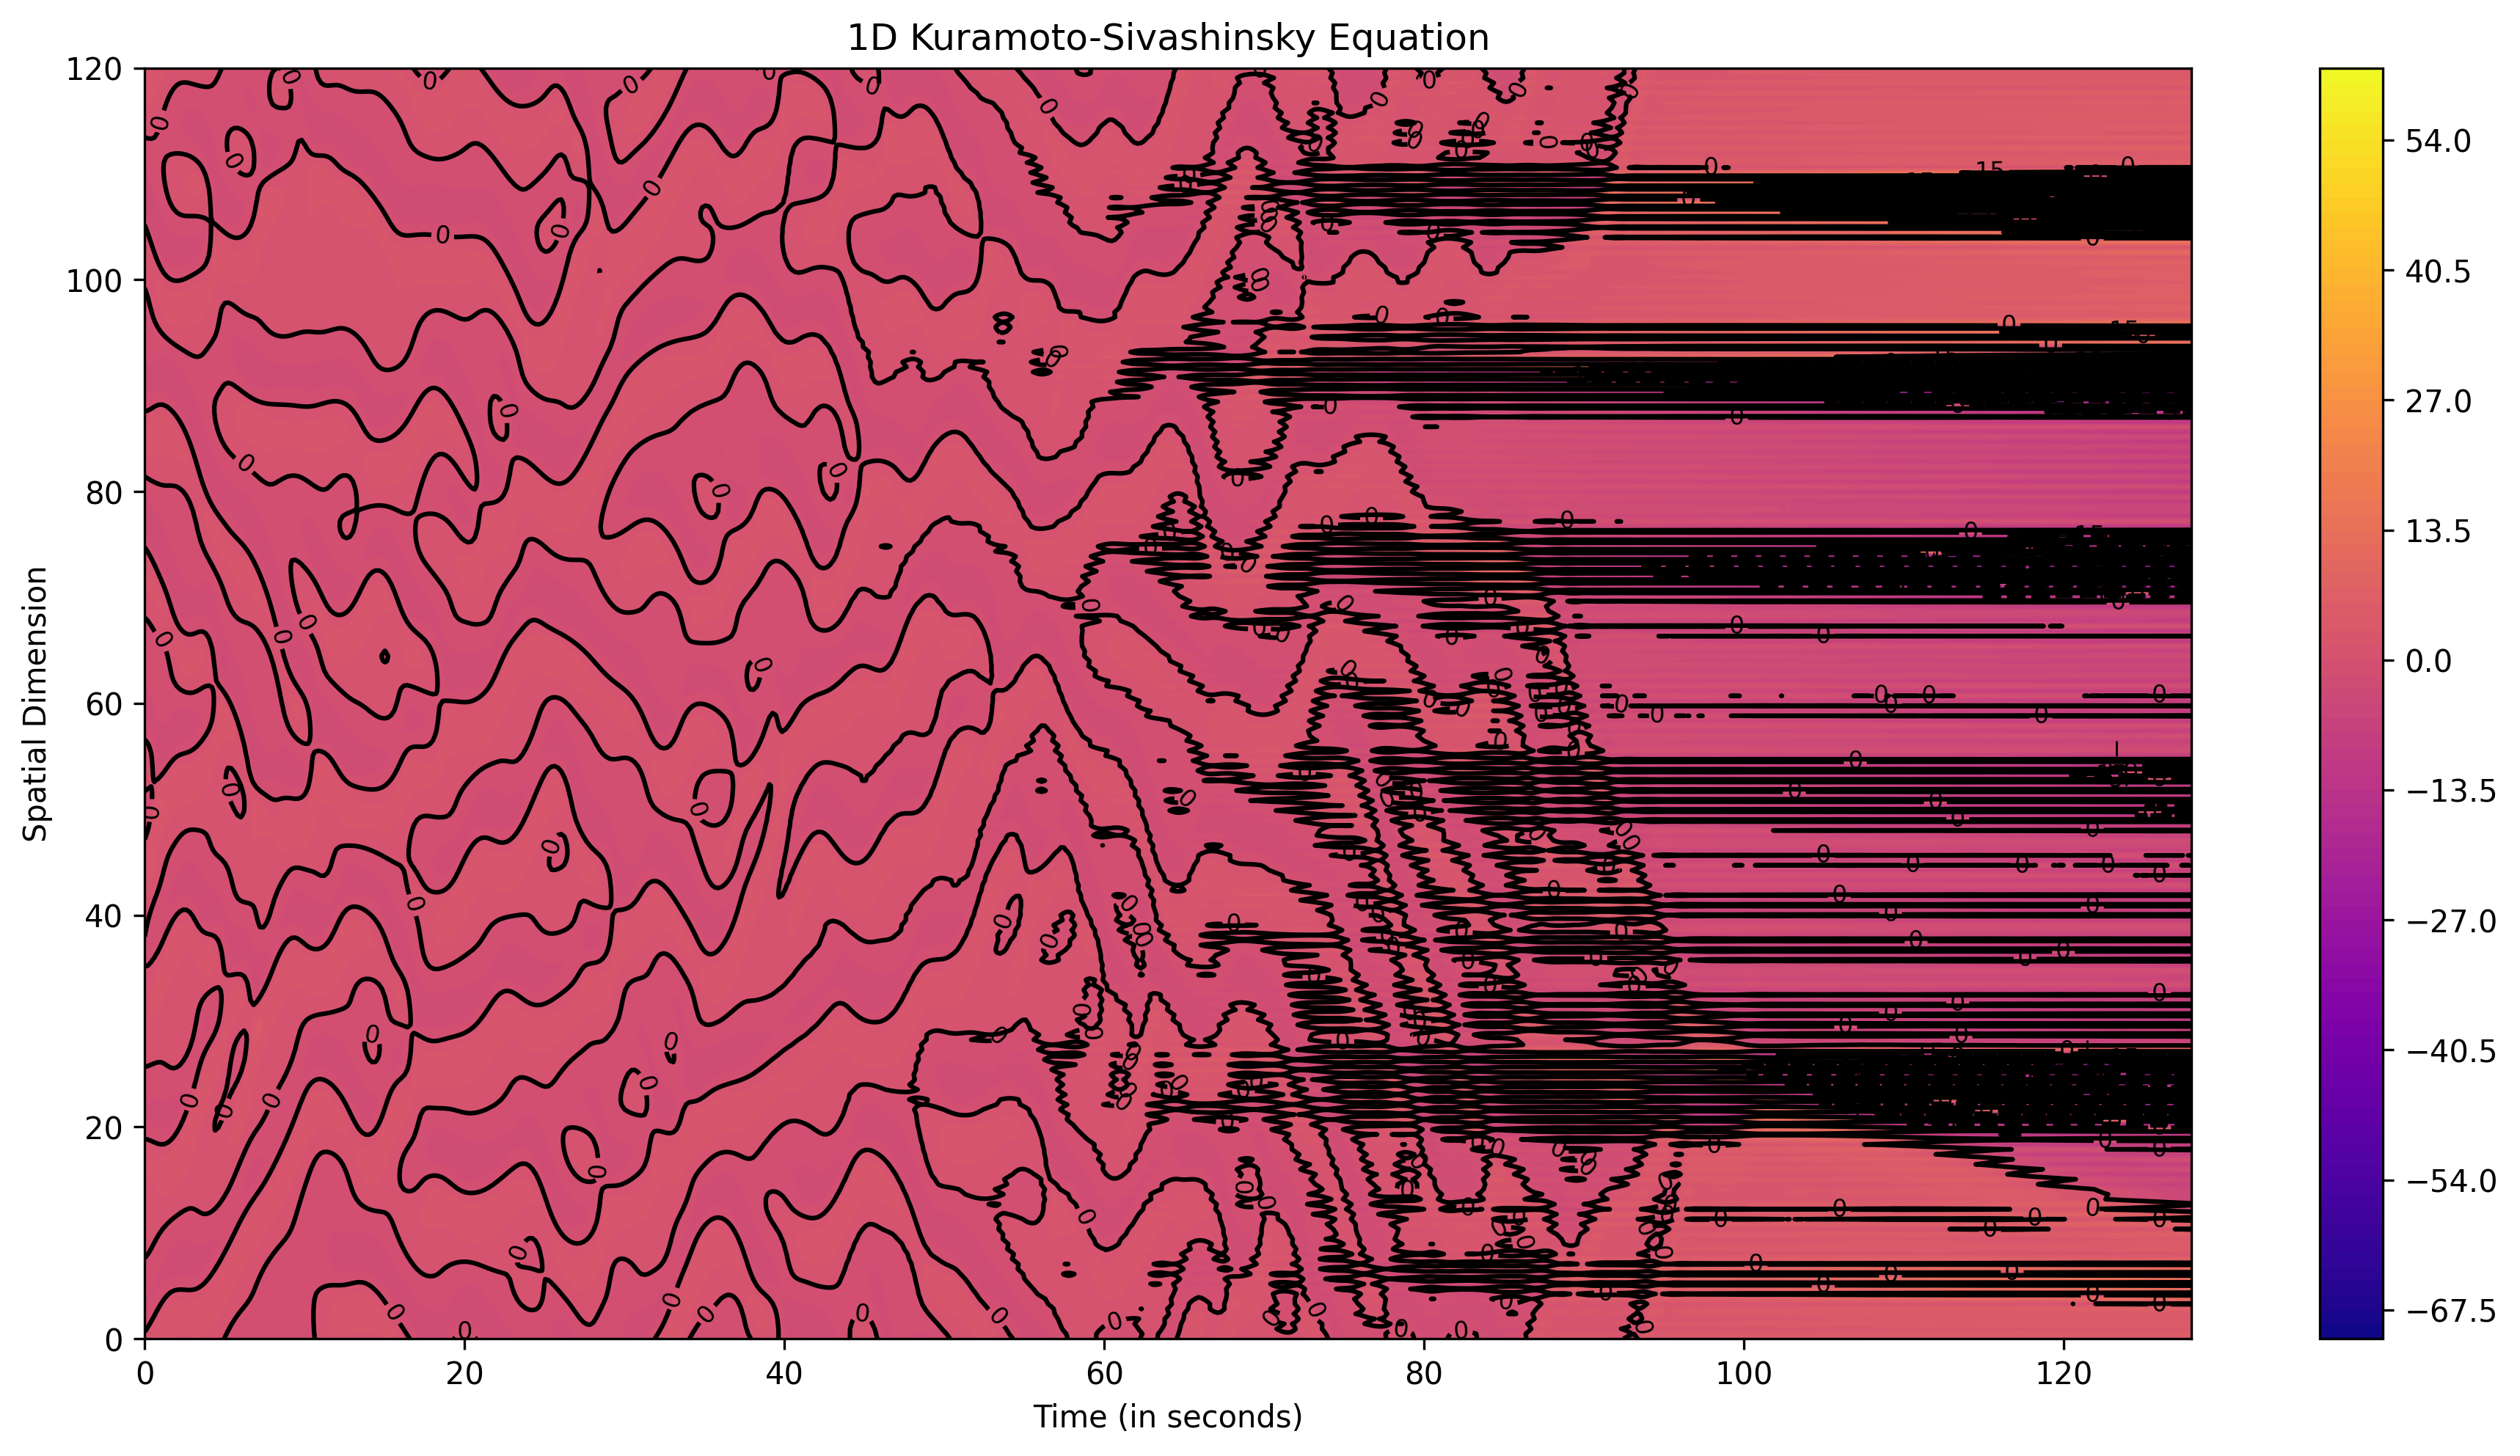

In [24]:
import numpy as np
import matplotlib.pyplot as plt

num_time_steps = predict.shape[0]
num_spatial_points = predict.shape[1]
t_start = 0
t_end = int(640 * 0.2)
x_start = 0
x_end = 120
t_eval = np.linspace(t_start, t_end, num_time_steps)
x = np.linspace(x_start, x_end, num_spatial_points)
T, X = np.meshgrid(t_eval, x)
plt.figure(figsize=(15, 7.5), dpi=300)
contourf = plt.contourf(T, X, predict.T, 100, cmap='plasma')
plt.colorbar(contourf)
contours = plt.contour(T, X, predict.T, 10, colors='black')
plt.clabel(contours, inline=True, fontsize=8)
plt.title('1D Kuramoto-Sivashinsky Equation')
plt.xlabel('Time (in seconds)')
plt.ylabel('Spatial Dimension')
plt.show()

In [21]:
def plot_kuramoto_sivashinsky(data, title, ax):
    num_time_steps = data.shape[0]
    num_spatial_points = data.shape[1]
    t_start = 0
    t_end = int(num_time_steps * 0.2)
    x_start = 0
    x_end = num_spatial_points
    t_eval = np.linspace(t_start, t_end, num_time_steps)
    x = np.linspace(x_start, x_end, num_spatial_points)
    T, X = np.meshgrid(t_eval, x)
    
    contourf = ax.contourf(T, X, data.T, 100, cmap='plasma')
    plt.colorbar(contourf, ax=ax)
    contours = ax.contour(T, X, data.T, 10, colors='black')
    ax.clabel(contours, inline=True, fontsize=8)
    ax.set_title(title)
    ax.set_xlabel('Time (in seconds)')
    ax.set_ylabel('Spatial Dimension')

In [22]:
def plot_comparison(truth, predict):
    diff = np.abs(truth - predict)
    fig, axs = plt.subplots(1, 3, figsize=(45, 15), dpi=100)
    plot_kuramoto_sivashinsky(truth, 'Ground Truth', axs[0])
    plot_kuramoto_sivashinsky(predict, 'Prediction', axs[1])
    plot_kuramoto_sivashinsky(diff, 'Difference (Absolute)', axs[2])
    plt.tight_layout()
    plt.show()

In [23]:
plot_comparison(truth, predict)

ValueError: operands could not be broadcast together with shapes (160,256) (640,256) 

- There is scaling we'll have to handle
- have u, dt, dx in file

In [13]:
from pdearena.visualization import plot_scalar, plot_2dvec, plot_scalar_sequence_comparison

In [ ]:
fig = plt.figure(figsize=(n_timesteps * 6 * scaling, 15))
ax1 = fig.add_subplot(gs[0, 0])

In [14]:
plot_scalar(scalar_field)

Signature: plot_scalar(ax, scalar: numpy.ndarray) -> matplotlib.image.AxesImage
Docstring:
Plot a scalar field.

Cleanups up the axes and returns the image object.

Args:
    ax (mpl.axes.Axes): Axes to plot on.
    scalar (np.ndarray): 2D Scalar field to plot.

Returns:
    (mpl.image.AxesImage): Image object.
File:      ~/git/pdearena/pdearena/visualization.py
Type:      function